In [65]:
import numpy as np
import matplotlib.pyplot as plt

## Linear model

In [176]:
class LinearModel(object):

    def __init__(self, A: np.ndarray, B: np.ndarray, C: np.ndarray, x0: np.ndarray) -> None:
        """
        :param A: state transition matrix 
        :param B: control matrix
        :param C: observation matrix
        :param x0: initial state
        """
        super().__init__()

        # system matrices
        self.A = A
        self.B = B
        self.C = C
        
        # state
        self.x = x0

    def predict(self, x: np.ndarray, u: np.ndarray) -> np.ndarray:
        return self.A@x + self.B*u

    def observe(self, x:np.ndarray)-> np.ndarray:
        return self.C@x


## Kalman filter

In [220]:
class KalmanFilter(object):
    def __init__(self, model: LinearModel, Q: np.ndarray, R: np.ndarray) -> None:
        """
        Kalman-filter class


        Notation: - hat: prediction
                  - bar: propagation

        :param model:
        :param Q: process/system noise covariance matrix
        :param R: measurement noise covariance matrix
        """
        super().__init__()
        self.model = model
        self.dim = self.model.A.shape[0]
        self.Q = Q  # system/process noise covariance
        self.R = R  # measurement noise covariance
        

        self.P_pred = 1e6 * np.eye(self.dim)
        self.x_pred = self.model.x

    def update(self, u, y):
        """
        Complete update of the Kalman-filter

        Notation: - K: Kalman gain
                  - S: innovation covariance matrix

        :param u: input vector
        :param y: measurement
        :return:
        """
        """Time update"""  # system dynamics
        # predict the state with the system model
        x_hat = self.model.predict(self.x_pred, u)
        
        # propagate covariance - it will be increased by two components:
        # 1. the transformed covariance matrix.
        # Note that APA' is nothing else than A(x-E[x])(x-E[x])'A'= {A(x-E[x])} {A(x-E[x])}',
        # which is the covariance of the transformed variable Ax
        # 2. the system/process noise (model inaccuracies not accounted for, e.g. not modeled effects, linearizations)
        P_hat = self.model.A @ self.P_pred @ self.model.A.T + self.Q

        """Measurement update"""  # incorporate measurement
        # temporary variables for accelerating computation
        P_hat_C_tr = P_hat @ self.model.C.T
        S_without_R = self.model.C @ P_hat_C_tr

        # Propagation of the covariance uncertainty toward the observation/output quantity - increased by two components as well
        # Note that implicitly here we have three components
        # 1. the (again) transformed covariance matrix
        # the first variable in S equals C P_hat C' = C (APA' + Q) C' = CAP(CA)' + CQC' + R, where
        # CAP(CA)' is the covariance of variable CAx
        # CQC' is the covariance accounting to system inaccuracies, mapped to the observations
        # R the covariance of the observation noise
        # 2. the observation noise (e.g. due to sensor noise)
        S = S_without_R + R

        # The Kalman gain is the optimal coefficient for incorporating measuement to correct the prediction (done in the time update)
        # It can be derived as minimizing the MSE of the state and its prediction
        # K can be written as
        #           (APA' + Q)C'
        # K = ----------------------
        #       C(APA' + Q)C' + R
        # i.e., if the observation is noisy (R is big), then K will be small, but if the model is not quite good (Q is big)
        # and/or the covariance of the state is big (i.e., P), then K will be appr. 1
        # Note that the Kalman gain will be always in (0;1] - in the scalar case. Thus, it has a contractive effect.
        K = P_hat_C_tr @ np.linalg.inv(S)

        # Innovation is an important concept in the theory of Kalman filtering.
        # This is the residual (basically, the new information), the model was not able to explain.
        # Thus, this should be incorporated into the posterior state
        innovation = y - self.model.C @ x_hat
        
        # To do that, we need to transform somehow from the observation space into the state space.
        # This is done with the Kalman gain.
        weighted_innovation = K @ innovation

        # Posterior state update
        # This can be written as : x_hat + K(y-Cx_hat) = (I-KC)x_hat + Ky, and this expression shed light on the form of
        # the posterior covariance (see below), as that is constructed by the covariance of (I-KC)x_hat - this is  (I-KC) P_hat (I-KC)' -,
        # and by the covariance of Ky, which is KRK'
        self.x_pred = x_hat + weighted_innovation
        
        # The Kalman gain is used for correcting the covariance as well
        # (the covariance P_hat predicted in the time update can be "reduced" by the new information of the observations)
        # A more intuitive (but computationally more burdensome) variant for the posterior covariance is
        # P = (I-KC) P_hat (I-KC)' + KRK'
        # This can be intuitively thought of as somehow trying to decrease the propoagated covariance P_hat and
        # the effect of the measurement noise covariance R
        self.P_pred = (np.eye(self.dim) - K @ self.model.C) @ P_hat
        
        return x_hat


## Example
Modeling acceleration, velocity, and distance

In [335]:
# Constants
NUM_STEPS = 500
T = 1e-2
NOISE_SCALE = .1

In [351]:
# model parameters
A = np.array([[1, T, T ** 2 / 2],
                  [0, 1, T],
                  [0, 0, 1]])
num_dim = A.shape[0]
B = np.array([0, 0, 1])
C = np.eye(num_dim)

# covariances
Q = 1e-2* np.eye(num_dim) # play around: what if Q -> infinity?
R = 1e-1 * np.eye(num_dim) # play around: what if R does not reflect the NOISE_SCALE?

# initial state
x0 = np.array([0, 0, 0.2])

In [352]:
model = LinearModel(A, B, C, x0)
kf = KalmanFilter(model, Q, R)

In [353]:
states = np.zeros((NUM_STEPS, num_dim))
truth = np.zeros((NUM_STEPS, num_dim))
u = 0. * np.sin(np.linspace(0, 5 * np.pi, NUM_STEPS))

for t in range(NUM_STEPS):
       
    # ground truth
    model.x = model.predict(model.x, u[t])
    truth[t,:] = model.x
    
    # KF
    x_hat = kf.update(u[t],model.x+NOISE_SCALE*np.random.rand(3))
    states[t,:] = kf.x_pred
    

In [354]:
residual = truth-states

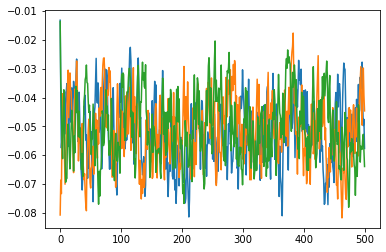

In [355]:
plt.plot(residual)

([array([ 10.,  29.,  72.,  95., 119., 100.,  44.,  25.,   5.,   1.]),
  array([  9.,  27.,  60., 109., 121.,  81.,  63.,  24.,   5.,   1.]),
  array([  3.,  18.,  69., 113., 108.,  80.,  61.,  40.,   7.,   1.])],
 array([-0.08171763, -0.07486234, -0.06800706, -0.06115177, -0.05429648,
        -0.0474412 , -0.04058591, -0.03373062, -0.02687533, -0.02002005,
        -0.01316476]),
 <a list of 3 Lists of Patches objects>)

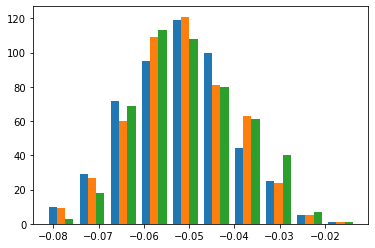

In [356]:
plt.hist(residual)

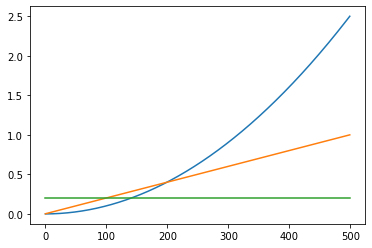

In [357]:
plt.plot(truth)

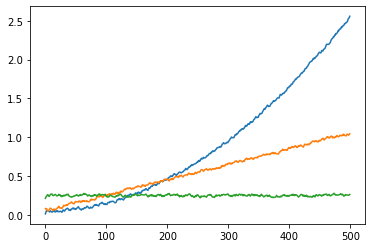

In [358]:
plt.plot(states)